In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import matplotlib.pyplot as plt
import time
import numpy as np
from copy import deepcopy
from huggingface_hub import login

torch.manual_seed(42)

# Funzione per il caricamento dati (etichette {-1, 1} per Hinge Loss)
def get_cats_vs_dogs_data():
    try:
        dataset = load_dataset("microsoft/cats_vs_dogs")
    except Exception as e:
        print(f"Errore durante il caricamento del dataset: {e}")
        return None, None
    train_dataset_subset = dataset['train'].shuffle(seed=42).select(range(2000))
    test_dataset_subset = dataset['train'].shuffle(seed=42).select(range(2000, 2500))
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    class CustomDataset(Dataset):
        def __init__(self, dataset, transform=None):
            self.dataset = dataset
            self.transform = transform
        def __len__(self):
            return len(self.dataset)
        def __getitem__(self, idx):
            item = self.dataset[idx]
            image = item['image'].convert("RGB")
            label = item['labels']
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(1 if label == 1 else -1, dtype=torch.float32)
    train_dataset = CustomDataset(train_dataset_subset, transform=transform)
    test_dataset = CustomDataset(test_dataset_subset, transform=transform)
    return train_dataset, test_dataset

In [5]:
# Classe del modello (invariata)
class TwoLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# --- Funzione di training per ottimizzatori nativi (Adam, Adagrad) ---
def train_native_optimizer(model, train_loader, test_loader, optimizer, device, num_epochs=15):
    train_losses, test_accuracies, train_times = [], [], []
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)
            outputs = model(images).squeeze()
            loss = torch.mean(torch.clamp(1 - labels * outputs, min=0))
            if torch.isnan(loss):
                print(f"!!! Training interrotto per {optimizer.__class__.__name__}: Loss è diventata NaN !!!")
                nan_results = [float('nan')] * (num_epochs - epoch)
                return train_losses + nan_results, test_accuracies + nan_results, train_times + nan_results
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Valutazione
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(images.size(0), -1).to(device)
                labels = labels.to(device)
                outputs = model(images).squeeze()
                predicted = torch.sign(outputs)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        epoch_time = time.time() - start_time
        train_times.append(epoch_time)
        print(f'Opt: {optimizer.__class__.__name__}, LR: {optimizer.param_groups[0]["lr"]}, BS: {train_loader.batch_size}, Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Acc: {accuracy:.2f}%, Time: {epoch_time:.2f}s')
    return train_losses, test_accuracies, train_times

# --- Funzione di training per SVRG ---
def get_grad(model, data_loader, device):
    model.zero_grad()
    for images, labels in data_loader:
        images = images.view(images.size(0), -1).to(device)
        labels = labels.to(device)
        outputs = model(images).squeeze()
        loss = torch.mean(torch.clamp(1 - labels * outputs, min=0))
        # Pesiamo la loss per la dimensione del batch per ottenere il gradiente totale corretto
        loss *= len(labels) / len(data_loader.dataset)
        loss.backward()

def train_svrg(model, train_loader, test_loader, lr, device, num_epochs=15):
    train_losses, test_accuracies, train_times = [], [], []
    full_grad_loader = DataLoader(train_loader.dataset, batch_size=len(train_loader.dataset), shuffle=False)

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        snapshot_model = deepcopy(model)
        get_grad(snapshot_model, full_grad_loader, device)

        running_loss = 0.0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)
            model.zero_grad()
            outputs_current = model(images).squeeze()
            loss = torch.mean(torch.clamp(1 - labels * outputs_current, min=0))
            loss.backward()
            grad_current = [p.grad.clone() for p in model.parameters()]

            snapshot_model.zero_grad()
            outputs_snapshot = snapshot_model(images).squeeze()
            torch.mean(torch.clamp(1 - labels * outputs_snapshot, min=0)).backward()
            grad_snapshot = [p.grad.clone() for p in snapshot_model.parameters()]

            with torch.no_grad():
                for i, p in enumerate(model.parameters()):
                    full_grad = list(snapshot_model.parameters())[i].grad
                    svrg_grad = grad_current[i] - grad_snapshot[i] + full_grad
                    p.data -= lr * svrg_grad
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Valutazione
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(images.size(0), -1).to(device)
                labels = labels.to(device)
                outputs = model(images).squeeze()
                predicted = torch.sign(outputs)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        epoch_time = time.time() - start_time
        train_times.append(epoch_time)
        print(f'Opt: SVRG, LR: {lr}, BS: {train_loader.batch_size}, Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Acc: {accuracy:.2f}%, Time: {epoch_time:.2f}s')
    return train_losses, test_accuracies, train_times

# --- Inizio Esperimento ---
input_size = 128 * 128 * 3
hidden_size = 500
output_size = 1
num_epochs = 10

# Iperparametri da testare
learning_rates = [0.005, 0.001]
batch_sizes = [64, 128]
optimizers_to_test = {'Adam': optim.Adam, 'Adagrad': optim.Adagrad, 'SVRG': 'custom'}
results = {}

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

train_dataset, test_dataset = get_cats_vs_dogs_data()

if train_dataset is not None:
    test_loader = DataLoader(dataset=test_dataset, batch_size=500, shuffle=False)

    for lr in learning_rates:
        for bs in batch_sizes:
            print(f"\n{'='*20} TESTING WITH LR={lr}, BS={bs} {'='*20}")
            train_loader = DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)

            for opt_name, opt_class in optimizers_to_test.items():
                print(f"\n--- Training with Optimizer: {opt_name} ---")
                # Re-inizializziamo il modello per ogni esperimento per un confronto equo
                torch.manual_seed(42) # Garantisce che ogni modello parta dagli stessi pesi
                model = TwoLayerNet(input_size, hidden_size, output_size).to(device)

                if opt_class == 'custom':
                    # Logica per SVRG
                    losses, accs, times = train_svrg(model, train_loader, test_loader, lr, device, num_epochs)
                else:
                    # Logica per Adam e Adagrad
                    optimizer = opt_class(model.parameters(), lr=lr)
                    losses, accs, times = train_native_optimizer(model, train_loader, test_loader, optimizer, device, num_epochs)

                results[(opt_name, lr, bs)] = {'losses': losses, 'accuracies': accs, 'times': np.cumsum(times)}

Using device: mps

==================== TESTING WITH LR=0.005, BS=64 ====================

--- Training with Optimizer: Adam ---
Opt: Adam, LR: 0.005, BS: 64, Epoch [1/10], Loss: 12.4316, Acc: 56.00%, Time: 6.44s
Opt: Adam, LR: 0.005, BS: 64, Epoch [2/10], Loss: 7.7878, Acc: 53.20%, Time: 6.48s
Opt: Adam, LR: 0.005, BS: 64, Epoch [3/10], Loss: 5.2607, Acc: 54.00%, Time: 6.71s
Opt: Adam, LR: 0.005, BS: 64, Epoch [4/10], Loss: 3.5350, Acc: 53.20%, Time: 6.69s
Opt: Adam, LR: 0.005, BS: 64, Epoch [5/10], Loss: 4.3620, Acc: 53.60%, Time: 6.53s
Opt: Adam, LR: 0.005, BS: 64, Epoch [6/10], Loss: 3.2009, Acc: 54.80%, Time: 7.19s
Opt: Adam, LR: 0.005, BS: 64, Epoch [7/10], Loss: 3.7885, Acc: 58.80%, Time: 8.58s
Opt: Adam, LR: 0.005, BS: 64, Epoch [8/10], Loss: 3.7184, Acc: 59.00%, Time: 7.51s
Opt: Adam, LR: 0.005, BS: 64, Epoch [9/10], Loss: 2.8186, Acc: 54.40%, Time: 7.12s
Opt: Adam, LR: 0.005, BS: 64, Epoch [10/10], Loss: 3.3024, Acc: 56.00%, Time: 6.88s

--- Training with Optimizer: Adagrad -

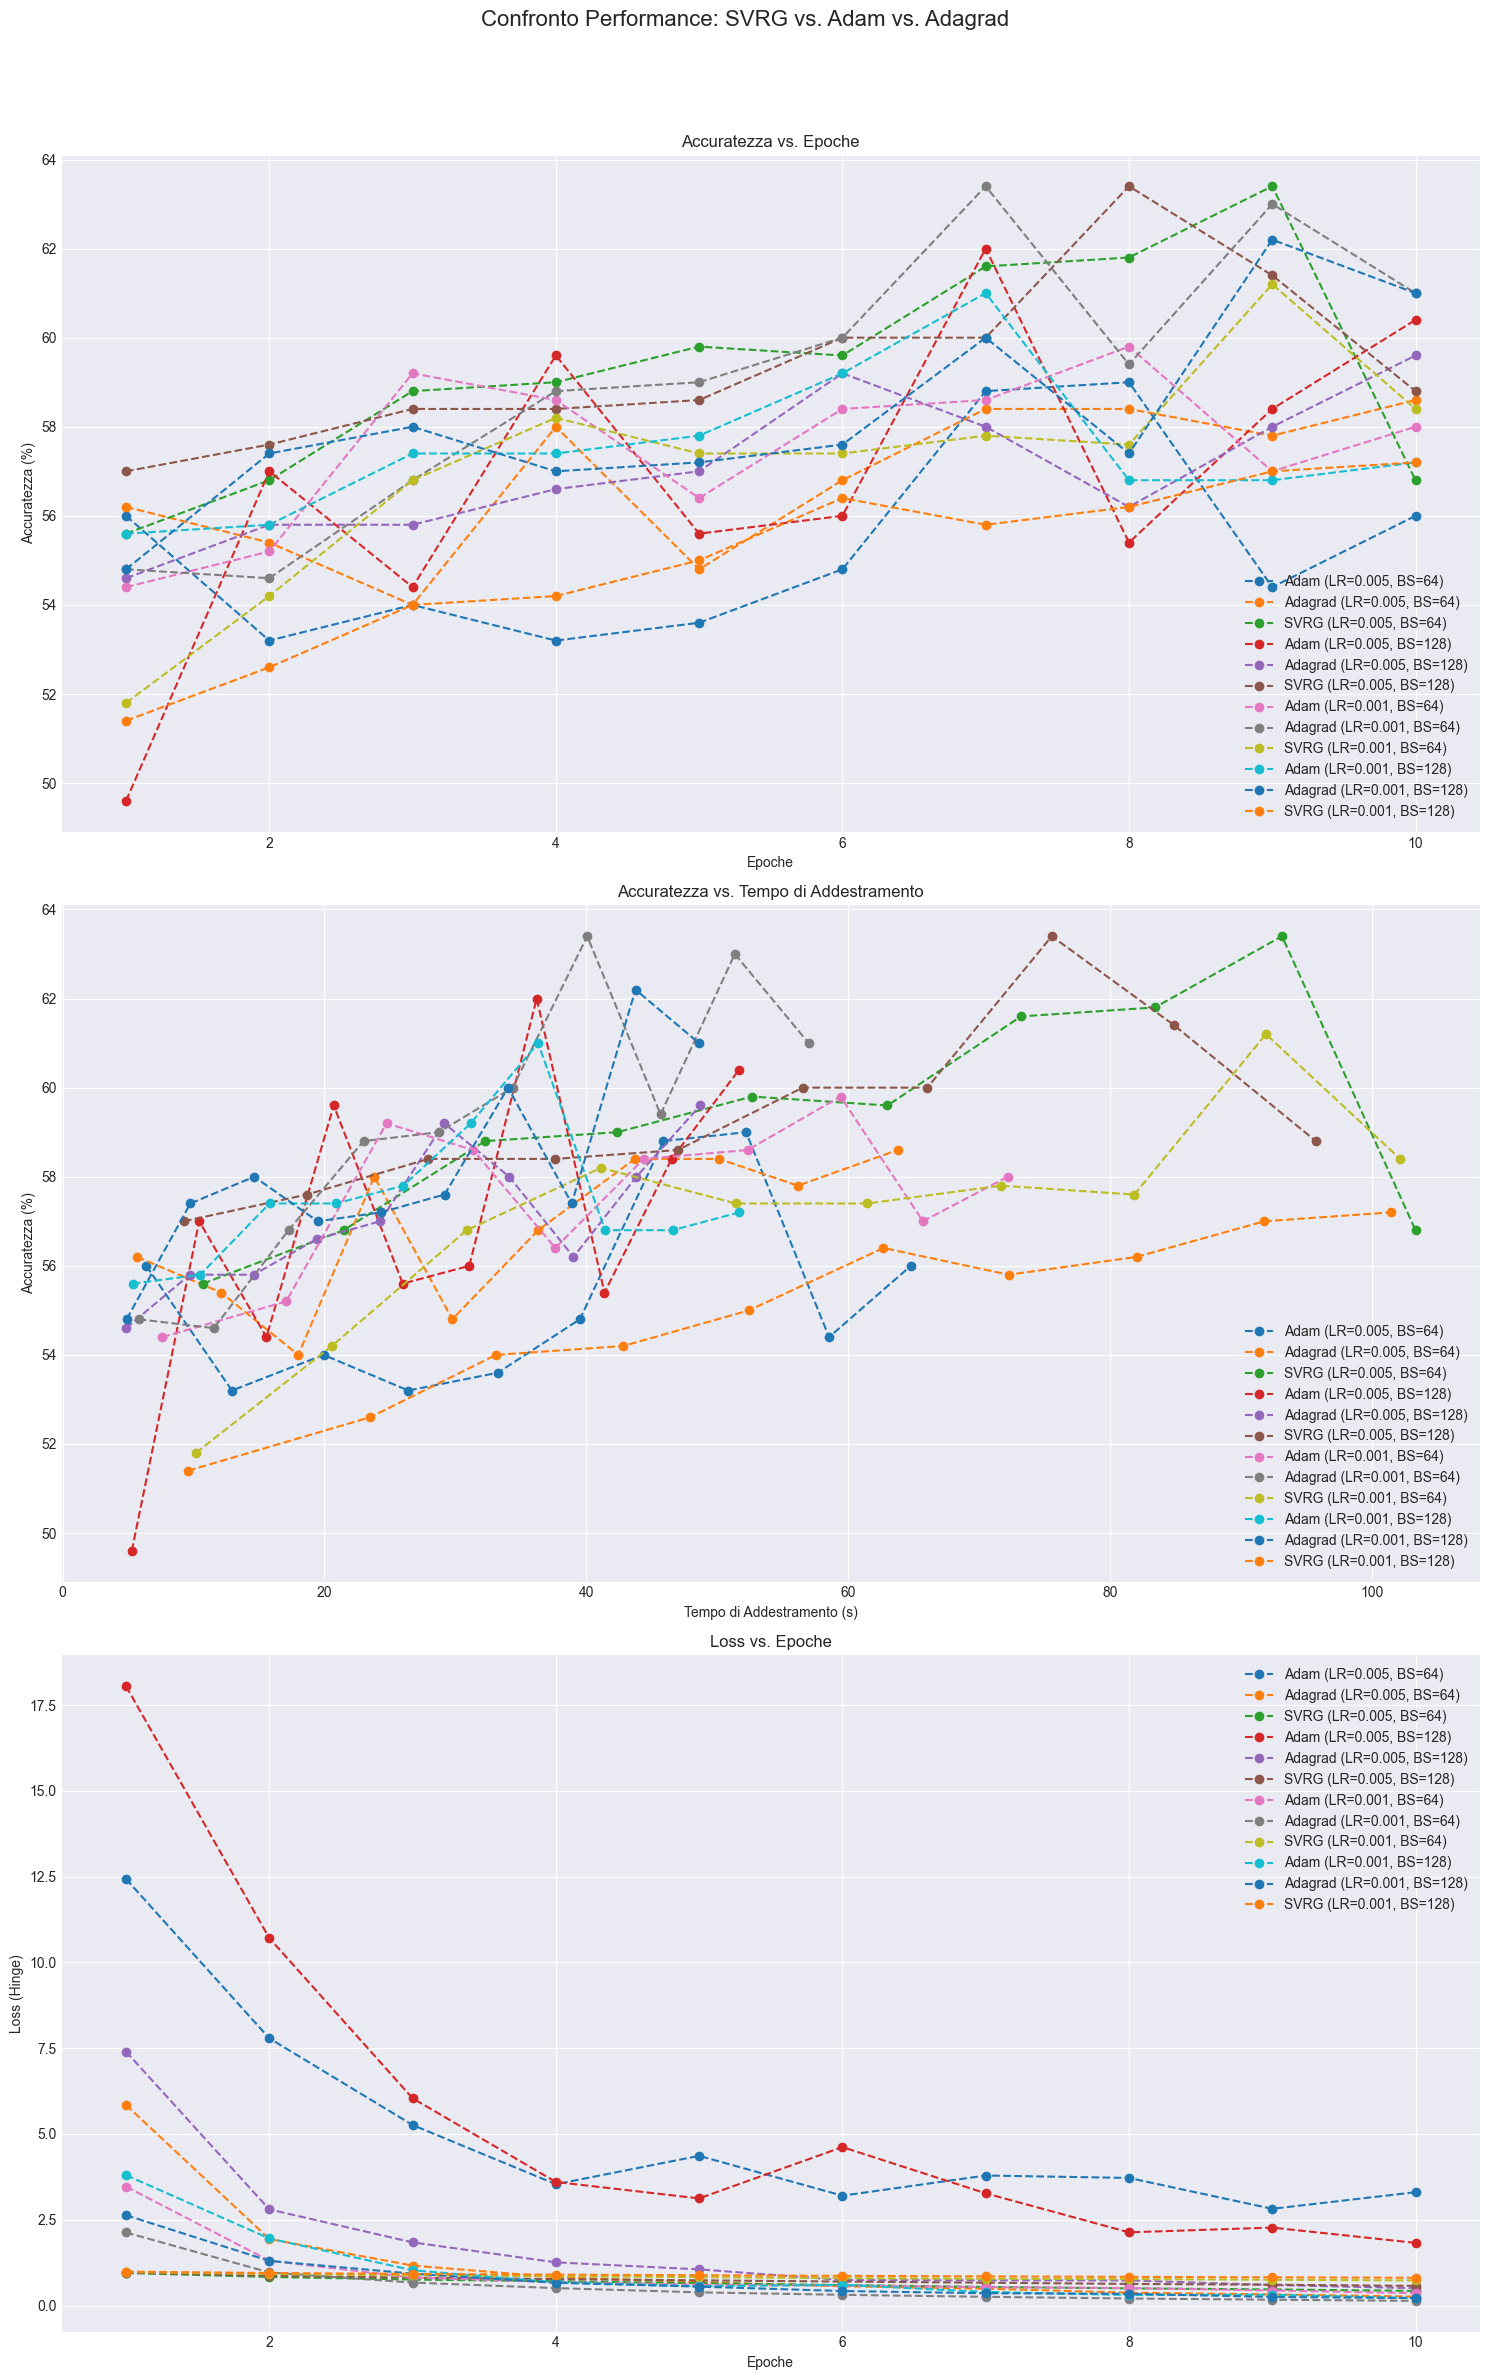

In [47]:
plt.style.use('seaborn-v0_8-darkgrid')
# Creiamo una figura con 3 subplots, uno sotto l'altro
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 25))
fig.suptitle('Confronto Performance: SVRG vs. Adam vs. Adagrad', fontsize=16)
for (opt_name, lr, bs), data in results.items():
    valid_indices = ~np.isnan(data['accuracies'])
    if not np.any(valid_indices): continue

    epochs = np.array(range(1, num_epochs + 1))[valid_indices]
    accuracies = np.array(data['accuracies'])[valid_indices]
    losses = np.array(data['losses'])[valid_indices]
    times = np.array(data['times'])[valid_indices]
    label = f'{opt_name} (LR={lr}, BS={bs})'

    # Grafico 1: Accuratezza vs. Epoche
    ax1.plot(epochs, accuracies, marker='o', linestyle='--', label=label)

    # Grafico 2: Accuratezza vs. Tempo
    ax2.plot(times, accuracies, marker='o', linestyle='--', label=label)
    # Grafico 3: Loss vs. Epoche
    ax3.plot(epochs, losses, marker='o', linestyle='--', label=label)
# Impostazione titoli e label per ogni grafico
ax1.set_title('Accuratezza vs. Epoche'); ax1.set_xlabel('Epoche'); ax1.set_ylabel('Accuratezza (%)'); ax1.legend(loc='lower right'); ax1.grid(True)
ax2.set_title('Accuratezza vs. Tempo di Addestramento'); ax2.set_xlabel('Tempo di Addestramento (s)'); ax2.set_ylabel('Accuratezza (%)'); ax2.legend(loc='lower right'); ax2.grid(True)
ax3.set_title('Loss vs. Epoche'); ax3.set_xlabel('Epoche'); ax3.set_ylabel('Loss (Hinge)'); ax3.legend(loc='upper right'); ax3.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
